<a href="https://colab.research.google.com/github/Mushfique12/IGTE/blob/ResNet/pinns_magnetostatic_poisson_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [43]:
pip install -U "ray[tune]"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
from typing import Callable

import matplotlib.pyplot as plt
import torch
from scipy.integrate import solve_ivp
from torch import nn
import numpy as np
import scipy.io
import time
import urllib

from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [45]:
# Checking for GPU
if torch.cuda.is_available():
  tensor = torch.rand(3, 4)
  tensor = tensor.to('cuda')
  print(f"Device tensor is stored on: {tensor.device}")

# Load data

In [46]:
# NN architecture in each subdomain
layers1 = [2, 400, 400, 100, 1]
# layers2 = [2, 400, 200, 100, 100, 1]
layers2 = [2, 100, 100, 40, 1]

mu1 = 1
mu2 = 1

Max_iter = 5000

# Data Preprocessing

In [47]:
def load_data():
  # Load training data (boundary points), residual and interface points from .mat file
  # All points are generated in Matlab
  # Download file from github
  !wget https://github.com/Mushfique12/IGTE/blob/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat?raw=true
  # Rename the file
  !mv PINN_Lin_mat.mat\?raw\=true PINN_Lin_mat.mat
  # Load the file
  data = scipy.io.loadmat('/content/PINN_Lin_mat.mat')

  # Boundary points from subdomian 1
  N_ub   = 250

  # Residual points in three subdomains
  N_f1   = 500
  N_f2   = 200

  # Interface points along the two interfaces
  N_I1   = 150

  x_f1 = data['x_domain'].flatten()[:,None]
  y_f1 = data['y_domain'].flatten()[:,None]
  x_f2 = data['x_coil'].flatten()[:,None]
  y_f2 = data['y_coil'].flatten()[:,None]

  x_i  = data['x_i'].flatten()[:,None]
  y_i  = data['y_i'].flatten()[:,None]

  x_boundary   = data['x_boundary'].flatten()[:,None]
  y_boundary   = data['y_boundary'].flatten()[:,None]

  u_boundary  = data['u_boundary'].flatten()[:,None]
  u_exact1 = data['u_domain'].flatten()[:,None]
  u_exact2 = data['u_coil'].flatten()[:,None]
  u_exacti = data['u_i'].flatten()[:,None]

  u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])

  u_exact1 = np.divide(u_exact1, u_exact.max())
  u_exact2 = np.divide(u_exact2, u_exact.max())
  u_exacti = np.divide(u_exacti, u_exact.max())
  u_boundary = np.divide(u_boundary, u_exact.max())

  X_f1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
  X_f2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))
  X_fi = np.hstack((x_i.flatten()[:,None], y_i.flatten()[:,None]))
  X_ub = np.hstack((x_boundary.flatten()[:,None], y_boundary.flatten()[:,None]))

  # Points in the whole  domain
  # x_total =  data['x_total'].flatten()[:,None] 
  # y_total =  data['y_total'].flatten()[:,None]

  # X_star1 = np.hstack((x_f1.flatten()[:,None], y_f1.flatten()[:,None]))
  # X_star2 = np.hstack((x_f2.flatten()[:,None], y_f2.flatten()[:,None]))

  # Randomly select the residual points from sub-domains
  idx1 = np.random.choice(X_f1.shape[0], N_f1, replace=False)    
  X_f1_train = np.float32(X_f1[idx1,:])

  idx2 = np.random.choice(X_f2.shape[0], N_f2, replace=False)    
  X_f2_train = np.float32(X_f2[idx2,:])

  # Randomly select boundary points
  idx4 = np.random.choice(X_ub.shape[0], N_ub, replace=False)
  X_ub_train = np.float32(X_ub[idx4,:])
  ub_train   = np.float32(u_boundary[idx4,:])

  # Randomly select the interface points along two interfaces
  idxi1 = np.random.choice(X_fi.shape[0], N_I1, replace=False)    
  X_fi_train = np.float32(X_fi[idxi1,:])
  ub_fi1_train = np.float32(u_exacti[idxi1,:])

  # List of all data
  train_data = [X_f1_train, X_f2_train, X_ub_train, ub_train, X_fi_train, ub_fi1_train]
  input_data = [X_f1, X_f2, X_fi, X_ub]
  plotting_data = [x_f1, x_f2, x_i, x_boundary, y_f1, y_f2, y_i, y_boundary, u_exact]

  return train_data, input_data, plotting_data

# Defining ML Architecture

In [48]:
class DenseResNet(nn.Module):
    """
    This is a ResNet Class.
    -> dim_in: network's input dimension
    -> dim_out: network's output dimension
    -> num_resnet_blocks: number of ResNet blocks
    -> num_layers_per_block: number of layers per ResNet block
    -> num_neurons: number of neurons in each layer
    -> activation: Non-linear activations function that you want to use. E.g. nn.Sigmoid(), nn.ReLU()
    -> fourier_features: whether to pass the inputs through Fourier mapping. E.g. True or False
    -> m_freq: how many frequencies do you want the inputs to be mapped to
    -> sigma: controls the spectrum of frequencies. 
              If sigma is greater more frequencies are consider. 
              You can also look at it as sampling from the standard normal, Z~N(0, 1), 
              and mapping to another normal, X~N(\mu, \sigma^2), using x = mu + sigma*z.
    -> tune_beta: do you want to consider the parameter beta in the activation functions in each layer? E.g., Tanh(beta*x).
                  In practice it is observed that training beta (i.e. tune_beta=True) could improve convergence. 
                  If tune_beta=False, you get the a fixed beta i.e. beta=1.
    -> The method model_capacity() returns the number of layers and parameters in the network.
    """
    def __init__(self, dim_in=2, dim_out=1, num_resnet_blocks=3, 
                 num_layers_per_block=2, num_neurons=50, activation=nn.Sigmoid(), 
                 fourier_features=False, m_freqs=100, sigma=10, tune_beta=False):
                 
        super(DenseResNet, self).__init__()

        self.num_resnet_blocks = num_resnet_blocks
        self.num_layers_per_block = num_layers_per_block
        self.fourier_features = fourier_features
        self.activation = activation
        self.activation_last = nn.Sigmoid()
        self.tune_beta = tune_beta

        if tune_beta:
            self.beta0 = nn.Parameter(torch.ones(1, 1)).to(device)
            self.beta = nn.Parameter(torch.ones(self.num_resnet_blocks, self.num_layers_per_block)).to(device)

        else: 
            self.beta0 = torch.ones(1, 1).to(device)
            self.beta = torch.ones(self.num_resnet_blocks, self.num_layers_per_block).to(device)

        self.first = nn.Linear(dim_in, num_neurons)

        self.resblocks = nn.ModuleList([
            nn.ModuleList([nn.Linear(num_neurons, num_neurons) 
                for _ in range(num_layers_per_block)]) 
            for _ in range(num_resnet_blocks)])

        self.last = nn.Linear(num_neurons, dim_out)

        if fourier_features:
            self.first = nn.Linear(2*m_freqs, num_neurons)
            self.B = nn.Parameter(sigma*torch.randn(dim_in, m_freqs)) # to converts inputs to m_freqs

    def forward(self, x):
        if self.fourier_features:
            cosx = torch.cos(torch.matmul(x, self.B))
            sinx = torch.sin(torch.matmul(x, self.B))
            x = torch.cat((cosx, sinx), dim=1)
            x = self.activation(self.beta0*self.first(x)) 

        else:
            x = self.activation(self.beta0*self.first(x))

        for i in range(self.num_resnet_blocks):
            z = self.activation(self.beta[i][0]*self.resblocks[i][0](x))

            for j in range(1, self.num_layers_per_block):
                z = self.activation(self.beta[i][j]*self.resblocks[i][j](z))

            x = z + x

        # out = self.activation_last(self.last(x))
        out = self.last(x)

        return out

    def model_capacity(self):
        """
        Prints the number of parameters and the number of layers in the network
        """
        number_of_learnable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        num_layers = len(list(self.parameters()))
        print("\n\nThe number of layers in the model: %d" % num_layers)
        print("\nThe number of learnable parameters in the model: %d" % number_of_learnable_params)  

In [49]:
class NNApproximator(nn.Module):
    def __init__(self, num_hidden: int, dim_hidden: int, act=nn.Sigmoid()):

        super().__init__()

        self.layer_in = nn.Linear(2, dim_hidden)
        self.layer_out = nn.Linear(dim_hidden, 1)

        num_middle = num_hidden - 1
        self.middle_layers = nn.ModuleList(
            [nn.Linear(dim_hidden, dim_hidden) for _ in range(num_middle)]
        )
        self.act = act
        self.activation_last = nn.Sigmoid()

    def forward(self, x):
        out = self.act(self.layer_in(x))
        for layer in self.middle_layers:
            out = self.act(layer(out))
        return self.activation_last(self.layer_out(out))


def f(nn: DenseResNet, x: torch.Tensor) -> torch.Tensor:
    """Compute the value of the approximate solution from the NN model"""
    return nn(x)


def df(nn: DenseResNet, x: torch.Tensor = None, order: int = 2) -> torch.Tensor:
    """Compute neural network derivative with respect to input features using PyTorch autograd engine"""
    df_value = f(nn, x)
    # print('x.shape', x.shape)
    # output_dim = [int(x.shape[0]), 1]
    # print('output_dim', output_dim)
    # output_ = torch.ones(output_dim)
    # print('output_shape', output_.shape)

    for _ in range(order):
        df_value = torch.autograd.grad(
            df_value,
            x,
            # grad_outputs=torch.ones(output_dim),
            torch.ones_like(df_value),
            # grad_outputs=torch.ones_like(x),
            create_graph=True,
            retain_graph=True,
        )[0]

    return df_value


def compute_loss(
    nn1: NNApproximator, 
    nn2: NNApproximator, 
    epoch : int = 0,
    x1: torch.Tensor = None, 
    x2: torch.Tensor = None, 
    xi: torch.Tensor = None, 
    xb: torch.Tensor = None, 
    ub: torch.Tensor = None,
    ufi: torch.Tensor = None,
    mult: int = 1,
    verbose: bool = False
) -> torch.float:

    """Compute the full loss function as interior loss + boundary loss
    This custom loss function is fully defined with differentiable tensors therefore
    the .backward() method can be applied to it
    """
    multiplier = mult
    interior_loss_1 = torch.sub(df(nn1, x1, order=2), torch.exp(x1))
    interior_loss_2 = torch.sub(df(nn2, x2, order=2), -50)

    u1_i = f(nn1, xi)
    u2_i = f(nn2, xi)
    uAvg_i = torch.mul(torch.add(u1_i, u2_i), 2)

    interface_loss_1 = torch.sub(uAvg_i, u1_i)
    interface_loss_2 = torch.sub(uAvg_i, u2_i)

    actual_interface_loss_1 = torch.sub(ufi, u1_i)
    actual_interface_loss_2 = torch.sub(ufi, u2_i)

    # Interface 1
    interface_1 = df(nn1, xi, order=2)
    interface_2 = df(nn2, xi, order=2)

    # Residual Continuity conditions on the interfaces
    res_loss = (interface_1 - torch.exp(xi)) - (interface_2 - (-50))
    
    # boundary = xb
    # boundary.requires_grad = True
    ub_pred = f(nn1, xb)
    boundary_loss = torch.sub(ub, ub_pred)

    if epoch % 2000 == 0:

      print(f"Loss at {epoch}: {interior_loss_1.pow(2).mean()}, {interface_loss_1.pow(2).mean()}, \
              domain: {interior_loss_2.pow(2).mean()}, {interface_loss_2.pow(2).mean()}, {boundary_loss.pow(2).mean()}")


    loss_1 = \
        interior_loss_1.pow(2).mean() + \
        multiplier * interface_loss_1.pow(2).mean() + \
        multiplier * boundary_loss.pow(2).mean() #+ \
        #multiplier * actual_interface_loss_1.pow(2).mean() #+ \
        #res_loss.pow(2).mean()

    loss_2 = \
        interior_loss_2.pow(2).mean() + \
        multiplier * interface_loss_2.pow(2).mean() #+ \
        #multiplier * actual_interface_loss_2.pow(2).mean() #+ \
        #res_loss.pow(2).mean()

    final_loss = loss_1 + loss_2

    loss_list = [interior_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_1.pow(2).mean().detach().cpu().numpy(), 
              interior_loss_2.pow(2).mean().detach().cpu().numpy(), 
              interface_loss_2.pow(2).mean().detach().cpu().numpy(), 
              boundary_loss.pow(2).mean().detach().cpu().numpy()]

    return final_loss, loss_list


def train_model(
    nn1: DenseResNet, 
    nn2: DenseResNet, 
    loss_fn: Callable,
    learning_rate: int = 0.01,
    max_epochs: int = 1000,
):

    loss_evolution_1, loss_evolution_2 = [], []
    interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss= [], [], [], [], []

    optimizer = torch.optim.NAdam([
                {'params': nn1.parameters(), 'lr': learning_rate},
                {'params': nn2.parameters(), 'lr': learning_rate}
            ])
    
  
    for epoch in range(max_epochs):

        try:
            loss, loss_list = loss_fn(nn1, nn2, epoch)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if epoch % 1000 == 0:
                print(f"Epoch: {epoch} - Loss # 1: {float(loss):>7f}")

            loss_evolution_1.append(loss.detach().cpu().numpy())

        except KeyboardInterrupt:
            break

        interior_loss_1.append(loss_list[0]) 
        interface_loss_1.append(loss_list[1]) 
        interior_loss_2.append(loss_list[2]) 
        interface_loss_2.append(loss_list[3]) 
        boundary_loss.append(loss_list[4])

        # print('===================================================================')
        # print('Here is the Loss Reported', float(loss.detach().cpu().numpy())) 
        # print('===================================================================')

        # Reporting to Ray Tune to stop bad performing trials early 
        tune.report(loss=float(loss.detach().cpu().numpy()))

    return [nn1, nn2], np.array(loss_evolution_1), np.array([interior_loss_1, interface_loss_1, interior_loss_2, interface_loss_2, boundary_loss])


def check_gradient(nn: DenseResNet, x: torch.Tensor = None) -> bool:

    eps = 1e-4
    dfdx_fd = (f(nn, x + eps) - f(nn, x - eps)) / (2 * eps)
    dfdx_sample = df(nn, x, order=1)

    return torch.allclose(dfdx_fd.T, dfdx_sample.T, atol=1e-2, rtol=1e-2)




In [50]:
# nn_approximator_1 = NNApproximator(4, 10)
# nn_approximator_2 = NNApproximator(2, 10)

In [51]:
# from torchsummary import summary
# print(nn_approximator_1)

In [52]:
# print(nn_approximator_2)

In [53]:
# type(X_f1_train[1, 0])

## Train Pinns

In [67]:
from functools import partial
import os

# domain = [0.0, 1.0]
# x = torch.linspace(domain[0], domain[1], steps=10, requires_grad=True)
# x = x.reshape(x.shape[0], 1)

def train_PINN(config={}, data=[], checkpoint_dir=None):

  # Hyperparameter Tuning
  # nn_approximator_1 = NNApproximator(config["num_hidden"], config["dim_hidden"], config["activation"])
  # nn_approximator_2 = NNApproximator(config["num_hidden"], config["dim_hidden"], config["activation"])
  # nn_approximator_1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=config["num_resnet_blocks"], 
  #                         num_layers_per_block=config["num_hidden"], num_neurons=config["dim_hidden"], activation=config["activation"], 
  #                         fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  # nn_approximator_2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=config["num_resnet_blocks"], 
  #                         num_layers_per_block=config["num_hidden"], num_neurons=config["dim_hidden"], activation=config["activation"], 
  #                         fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  # multiplier = config["multiplier"]
  # lr = config["lr"]
  # max_epochs = config["epochs"]

  # Hyperparameters
  # nn_approximator_1 = NNApproximator(2, 32, nn.Sigmoid())
  # nn_approximator_2 = NNApproximator(2, 32, nn.Sigmoid())
  nn_approximator_1 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                          num_layers_per_block=2, num_neurons=50, activation=nn.Tanh(), 
                          fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  nn_approximator_2 = DenseResNet(dim_in=2, dim_out=1, num_resnet_blocks=3, 
                          num_layers_per_block=2, num_neurons=50, activation=nn.Tanh(), 
                          fourier_features=False, m_freqs=100, sigma=10, tune_beta=False)
  multiplier = 60
  lr = 0.0621
  max_epochs = 15000



  device = "cpu"
  if torch.cuda.is_available():
    device = "cuda:0"
    if torch.cuda.device_count() > 1:
      nn_approximator_1 = nn.DataParallel(nn_approximator_1)
      nn_approximator_2 = nn.DataParallel(nn_approximator_2)
  nn_approximator_1.to(device)
  nn_approximator_2.to(device)

  # Load the data
  X_f1_train, X_f2_train, X_ub_train, ub_train, X_fi_train, ub_fi1_train = [data[i] for i in (0, 1, 2, 3, 4, 5)]

  x1 = torch.tensor(X_f1_train, requires_grad=True)
  x2 = torch.tensor(X_f2_train, requires_grad=True) 
  xi = torch.tensor(X_fi_train, requires_grad=True) 
  xb = torch.tensor(X_ub_train, requires_grad=True)
  ub = torch.tensor(ub_train)
  ub = torch.zeros_like(ub)
  ufi = torch.tensor(ub_fi1_train)

  x1 = x1.to(device)
  x2 = x2.to(device)
  xi = xi.to(device)
  xb = xb.to(device)
  ub = ub.to(device)
  ufi = ufi.to(device)

  #rint(f"Device x1 is stored on: {x1.device}")
  #print(f"Device x2 is stored on: {x2.device}")


  # assert check_gradient(nn_approximator, x)

  # f_initial = f(nn_approximator, x)
  # ax.plot(x.detach().numpy(), f_initial.detach().numpy(), label="Initial NN solution")

  # if checkpoint_dir:
  #   model_state = torch.load(
  #       os.path.join(checkpoint_dir, "checkpoint"))
  #   net.load_state_dict(model_state)
    # optimizer.load_state_dict(optimizer_state)

  # train the PINN
  loss_fn = partial(compute_loss,     
                    x1 = x1, 
                    x2 = x2, 
                    xi = xi, 
                    xb = xb, 
                    ub = ub,
                    ufi = ufi,
                    mult = multiplier,
                    verbose=True)

  nn_approximator_trained, loss_evolutions, loss_array = train_model(
                                                                    nn_approximator_1,
                                                                    nn_approximator_2,
                                                                    loss_fn=loss_fn, 
                                                                    learning_rate=lr, 
                                                                    max_epochs=max_epochs
                                                                  )

  print("Finished Training")

  return nn_approximator_trained, loss_evolutions, loss_array

  # x_eval = torch.linspace(domain[0], domain[1], steps=100).reshape(-1, 1)

In [74]:
# Load Data
train_data, input_data, plotting_data = load_data()

nn_approximator_trained, loss_evolutions, loss_array = train_PINN(data=train_data)

--2022-08-26 09:56:09--  https://github.com/Mushfique12/IGTE/blob/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-26 09:56:09--  https://github.com/Mushfique12/IGTE/raw/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat [following]
--2022-08-26 09:56:10--  https://raw.githubusercontent.com/Mushfique12/IGTE/82629c9165acb94b7c2ec77d054b9a3cbd314d06/PINN_Lin_mat.mat
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.

    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python3.7/dist-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/usr/local/lib/python3.7/dist-packages/ipykernel/kernelapp.py", line 612, in start
    self.io_loop.start()
  File "/usr/local/lib/python3.7/dist-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
    self._run_once()
  File "/usr/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
    handle._run()
  File "/usr/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/usr/local/lib/python3.7/dist-packages/tornado/ioloop.py", line 758, in _ru

Loss at 0: 1.6060397624969482, 0.030332602560520172,               domain: 2499.22900390625, 0.0015894795069471002, 0.04667232185602188
Epoch: 0 - Loss # 1: 2505.550781
Epoch: 1000 - Loss # 1: 10.992805
Loss at 2000: 0.773738443851471, 0.02366856299340725,               domain: 0.6982380151748657, 0.006829435005784035, 0.00887515489012003
Epoch: 2000 - Loss # 1: 3.834366
Epoch: 3000 - Loss # 1: 1.927942
Loss at 4000: 0.4325166642665863, 0.024013595655560493,               domain: 0.6347076892852783, 0.008586365729570389, 0.005345799028873444
Epoch: 4000 - Loss # 1: 3.343970
Epoch: 5000 - Loss # 1: 3.063531
Loss at 6000: 0.5442556142807007, 0.460364431142807,               domain: 0.5101224780082703, 0.26571959257125854, 0.027595562860369682
Epoch: 6000 - Loss # 1: 46.275154
Epoch: 7000 - Loss # 1: 1.439018
Loss at 8000: 0.5816351771354675, 0.011813749559223652,               domain: 0.38409939408302307, 0.003380405018106103, 0.0031167827546596527
Epoch: 8000 - Loss # 1: 2.064391
Epoch:

# Hyper-Parameter Tuning

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10729937542159573399
 xla_global_id: -1]

In [ ]:
max_num_epochs = 45000
num_samples = 15
gpus_per_trial = 0
cpus_per_trial = 1

config = {
        "num_resnet_blocks": tune.grid_search([2, 3, 4]),
        "num_hidden": tune.sample_from(lambda _: np.random.randint(2, 6)),
        "dim_hidden": tune.sample_from(lambda _: 2 ** np.random.randint(5, 10)),        
        "activation": tune.grid_search([nn.Sigmoid(), nn.Tanh()]),
        "lr": tune.loguniform(1e-4, 1e-1),
        "multiplier": tune.grid_search([30, 60, 90]),
        "epochs": tune.grid_search([30000, 45000])
    }

# Load Data
train_data, input_data, plotting_data = load_data()

scheduler = ASHAScheduler(
        metric="loss",
        mode="min",
        max_t=max_num_epochs,
        grace_period=1,
        reduction_factor=2)

reporter = CLIReporter(
    # parameter_columns=["l1", "l2", "lr", "batch_size"],
    metric_columns=["loss", "training_iteration"])

result = tune.run(
    partial(train_PINN, data=data),
    resources_per_trial={"cpu": cpus_per_trial, "gpu": gpus_per_trial},
    config=config,
    num_samples=num_samples,
    scheduler=scheduler,
    progress_reporter=reporter)

best_trial = result.get_best_trial("loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final loss: {}".format(best_trial.last_result["loss"]))

In [ ]:
best_trial = result.get_best_trial("loss", "min", "last")
print(best_trial)

# Plotting Each losses


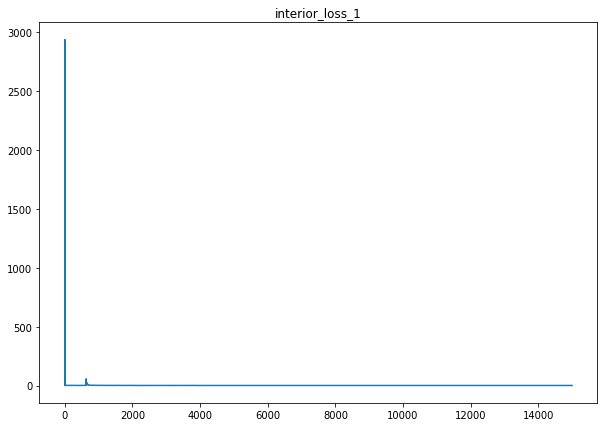

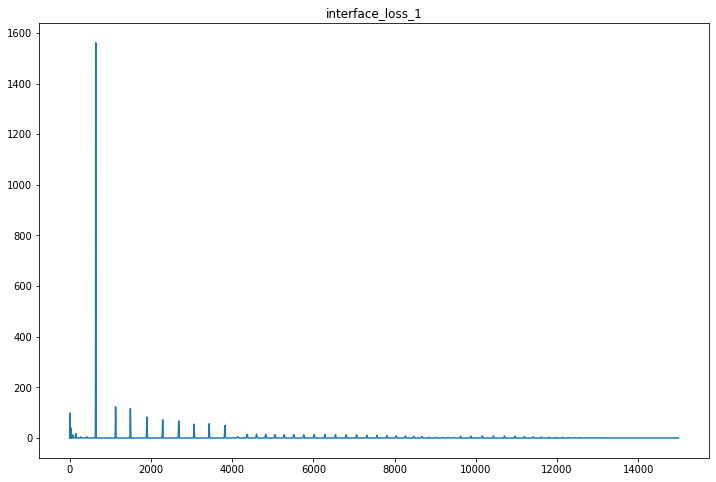

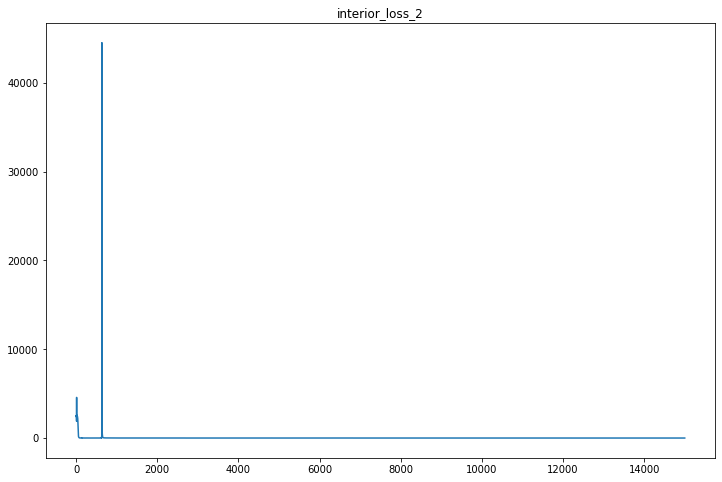

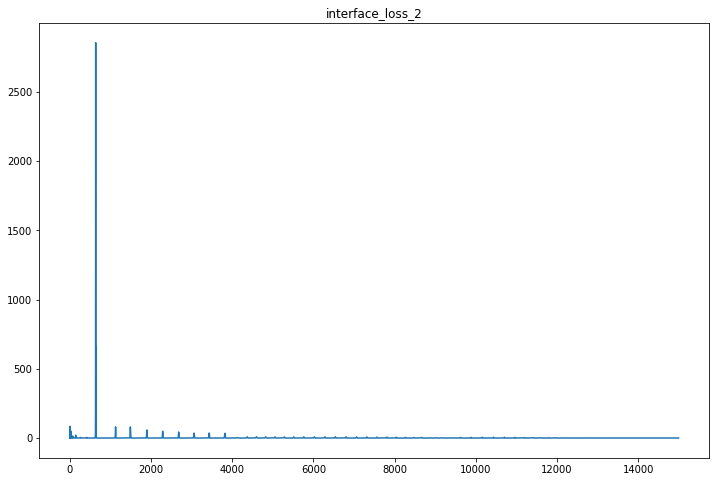

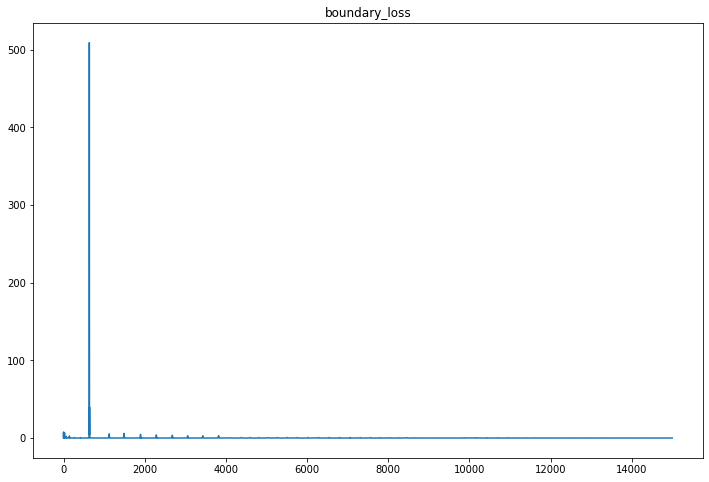

In [75]:
fig = plt.figure(figsize=(10, 7))

plt.plot(loss_array[0, :])
plt.title('interior_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[1, :])
plt.title('interface_loss_1')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[2, :])
plt.title('interior_loss_2')
plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[3, :])
plt.title('interface_loss_2')

plt.show()

fig = plt.figure(figsize=(12, 8))

plt.plot(loss_array[4, :])
plt.title('boundary_loss')

plt.show()

# Predict Output


In [76]:
# Solution prediction
nn1_trained = nn_approximator_trained[0]
nn2_trained = nn_approximator_trained[1]

nn1_trained.beta.to("cpu")
print(nn1_trained.beta.is_cuda)
# nn1_trained.beta0.cpu()
# print(nn1_trained.beta0.is_cuda)
# nn2_trained.beta.cpu()
# nn2_trained.beta0.cpu()

u_pred1 = nn1_trained(torch.tensor(np.float32(input_data[0]))).detach().numpy()
u_pred2 = nn2_trained(torch.tensor(np.float32(input_data[1]))).detach().numpy()

u_pred_i1 = nn1_trained(torch.tensor(np.float32(input_data[2]))).detach().numpy()
u_pred_i2 = nn2_trained(torch.tensor(np.float32(input_data[2]))).detach().numpy()

u_pred_b = nn2_trained(torch.tensor(np.float32(input_data[3]))).detach().numpy()

u_pred = np.concatenate([u_pred1, u_pred2, (u_pred_i1 + u_pred_i2)/2, u_pred_b])

False


In [ ]:
# u_exact1 = data['u_domain'].flatten()[:,None]
# u_exact2 = data['u_coil'].flatten()[:,None]

# u_exacti = data['u_i'].flatten()[:,None]

# u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])


In [ ]:
# u_exact1 = np.divide(u_exact1, u_exact.max())
# print(u_exact1.max(), u_exact1.min())

In [ ]:
# u_exact2 = np.divide(u_exact2, u_exact.max())
# print(u_exact2.max(), u_exact2.min())

In [ ]:
# u_exacti = np.divide(u_exacti, u_exact.max())
# print(u_exacti.max(), u_exacti.min())

In [ ]:
# u_boundary = np.divide(u_boundary, u_exact.max())
# print(u_boundary.max(), u_boundary.min())

In [ ]:
# u_exact = np.concatenate([u_exact1, u_exact2, u_exacti, u_boundary])


## Max values

u max: 2.2

u min: 0


In [77]:
x_f1, x_f2, x_i, x_boundary, y_f1, y_f2, y_i, y_boundary, u_exact = [plotting_data[i] for i in (0, 1, 2, 3, 4, 5, 6, 7, 8)]

In [78]:
x_tot = np.concatenate([x_f1, x_f2, x_i, x_boundary])
y_tot = np.concatenate([y_f1, y_f2, y_i, y_boundary])
print(x_tot.shape, y_tot.shape, u_pred.shape, u_exact.shape)

(2693, 1) (2693, 1) (2693, 1) (2693, 1)


# Plotting Contours


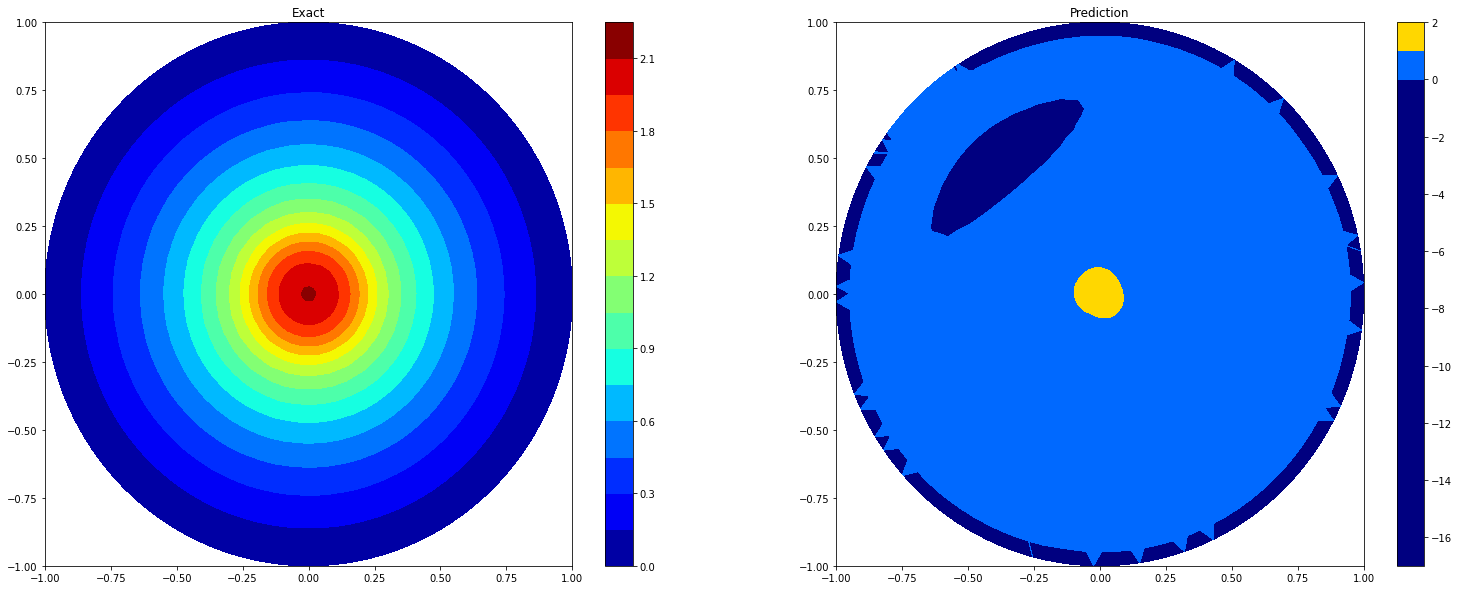

In [79]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import numpy as np


np.random.seed(19680801)
npts = 200
ngridx = 100
ngridy = 200
x = x_tot.squeeze()
y = y_tot.squeeze()
up = u_pred.squeeze()
uex = u_exact.squeeze()

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(26,10))
vmin=0
vmax=2.2

## True Exact
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr1 = ax1.tricontourf(x, y, uex, levels=20, vmin=vmin, vmax=vmax, cmap="jet")

fig.colorbar(cntr1, ax=ax1)
# ax2.plot(x, y, 'ko', ms=3)
ax1.set(xlim=(-1, 1), ylim=(-1, 1))
ax1.set_title('Exact')


## Predictions
# ax2.tricontour(x, y, z, levels=20, linewidths=0.5, colors='k')
cntr2 = ax2.tricontourf(x, y, up, levels=20, vmin=vmin, vmax=vmax, cmap="jet")

fig.colorbar(cntr2, ax=ax2)
# ax2.plot(x, y, 'ko', ms=3)
ax2.set(xlim=(-1, 1), ylim=(-1, 1))
ax2.set_title('Prediction')

plt.subplots_adjust(hspace=0.5)
# plt.savefig('exact_pred_TL_20points.png', dpi=400)
plt.show()

## Rough

In [ ]:
# # numeric solution
# def logistic_eq_fn(x, y):
#     return R * x * (1 - x)

# numeric_solution = solve_ivp(
#     logistic_eq_fn, domain, [F0], t_eval=x_eval.squeeze().detach().numpy()
# )

# # plotting
# fig, ax = plt.subplots()

# f_final_training = f(nn_approximator_trained, x)
# f_final = f(nn_approximator_trained, x_eval)

# ax.scatter(x.detach().numpy(), f_final_training.detach().numpy(), label="Training points", color="red")
# ax.plot(x_eval.detach().numpy(), f_final.detach().numpy(), label="NN final solution")
# ax.plot(
#     x_eval.detach().numpy(),
#     numeric_solution.y.T,
#     label=f"Analytic solution",
#     color="green",
#     alpha=0.75,
# )
# ax.set(title="Logistic equation solved with NNs", xlabel="t", ylabel="f(t)")
# ax.legend()

# fig, ax = plt.subplots()
# ax.semilogy(loss_evolution)
# ax.set(title="Loss evolution", xlabel="# epochs", ylabel="Loss")
# ax.legend()

# plt.show()